# UPC Quantum Engineering Final Project: Quantum Channel Discrimination
## II. One-shot discrimination Base circuit

In [51]:
from itertools import product, combinations
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
from qiskit import Aer, execute
from numpy import pi
from math import e
import matplotlib.pyplot as plt
import numpy as np
import math

In [52]:
# Create 2 qbits circuit and 1 output classical bit
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(1, 'c')
T = 10  # Points of Theta angle (pi) in Bloch sphere - min 2
P = 20  # Points of Phase angle (2*pi) in Bloch sphere - min 2
angle = pi/1.5  # Angle used for CY gate
cycles = 5000  # Number of iterations in execution

# Quantum states to pass through the circuit
# We want to pass the Bloch sphere through it to see visually the transformation
# First we generate the angles which will help the draw the sphere
Theta = np.mgrid[0:pi:T*1j]
Phase = np.mgrid[0:2*pi:P*1j]
# As we have to provide the state values to initialize the qreg[0] we have to do a conversion
# from angles in the sphere to statevector amplitudes. These statevectors will be the combination of
# Zero_Amplitude*|0> plus One_Amplitude*|1>
Zero_Amplitude = [0]*T*P
One_Amplitude = [0]*T*P
Zero_AmplitudeF = [0]*T*P
One_AmplitudeF = [0]*T*P
Zero_AmplitudeF2 = [0]*T*P
One_AmplitudeF2 = [0]*T*P

In [53]:
print('Preparing states to pass through the circuit')
for a in range(len(Theta)):
    for b in range(len(Phase)):
        Zero_Amplitude[a*P+b] = math.cos(Theta[a]/2)
        One_Amplitude[a*P+b] = math.sin(Theta[a]/2)*e**(1j*Phase[b])
# List of Initial States
#        print("State ", a*P+b," =", Zero_Amplitude[a*P+b],"*|0> + ", One_Amplitude[a*P+b], "*|1>")

# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')
# Run the quantum circuit on a statevector simulator backend
backend = Aer.get_backend('statevector_simulator')

totalResults = []
totalCounts = []
totalCircuits = []
totalStateVectors = []

Preparing states to pass through the circuit


In [54]:
def convertCountsToFinalState(inCounts):
    countsZero = 0
    countsOne = 0

    if "0" in inCounts:
        countsZero = inCounts["0"]
    if "1" in inCounts:
        countsOne = inCounts["1"]

    totalCycles = countsZero + countsOne
    
    return {
        "zeroAmplitude": np.sqrt(countsZero/totalCycles),
        "oneAmplitude": np.sqrt(countsOne/totalCycles),
    }

In [55]:
print("Defining the circuit")
# Create the circuit gates
# Not used as we defined the angle and don't iterate circuits
# print("Starting to compute the angle: ", math.degrees(theta))

# Initialize circuit with desired initial_state
print("Initializing the circuit")

for i in range(len(Zero_Amplitude)):
    circuit = QuantumCircuit(qreg_q, creg_c)
    circuit.initialize([Zero_Amplitude[i], One_Amplitude[i]], qreg_q[0])
   #print("Input State ", i, " =",
    #      np.round(Zero_Amplitude[i], 3), "*|0> + ", np.round(One_Amplitude[i],3), "*|1>")
    circuit.reset(qreg_q[1])
    circuit.cry(angle, qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[1], qreg_q[0])
    circuit.measure(qreg_q[0], creg_c[0])
    totalCircuits.append(circuit)
    # execute circuit on backends
    job_sim = execute(circuit, backend_sim, shots=cycles)
    job = execute(circuit, backend, shots=cycles)
    # get results
    result = job.result()
    results_sim = job_sim.result()
    outputState = result.get_statevector(circuit, decimals=3)
    totalStateVectors.append(outputState);
    #print("Output State Vector: ", outputState)
    totalResults.append(results_sim)
    counts = results_sim.get_counts(circuit)
    finalState = convertCountsToFinalState(counts)
    Zero_AmplitudeF[i] = finalState["zeroAmplitude"]
    One_AmplitudeF[i] = finalState["oneAmplitude"]
    # Zero_AmplitudeF[i] = np.sqrt(counts['0']/cycles)
    # One_AmplitudeF[i] = np.sqrt((cycles-counts['0'])/cycles)
    #print("Output State ", i, " =",
    #      np.round(Zero_AmplitudeF[i],3), "*|0> + ", np.round(One_AmplitudeF[i],3), "*|1>")
    totalCounts.append(counts)

Defining the circuit
Initializing the circuit


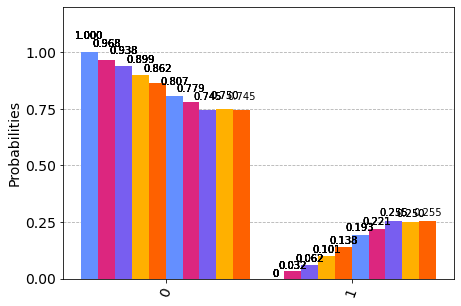

In [56]:
plot_histogram([totalCounts[0], totalCounts[int((len(totalCounts)/10)*2)], totalCounts[int((len(totalCounts)/10)*3)], totalCounts[int((len(totalCounts)/10)*4)], totalCounts[int((len(totalCounts)/10)*5)], totalCounts[int((len(totalCounts)/10)*6)],totalCounts[int((len(totalCounts)/10)*7)], totalCounts[int((len(totalCounts)/10)*8)], totalCounts[int((len(totalCounts)/10)*9)], totalCounts[(int((len(totalCounts)/10)*10))-1]])

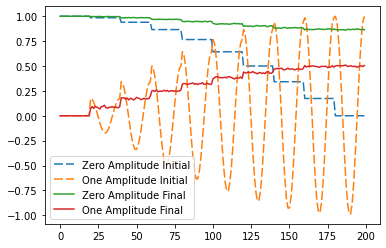

In [57]:
fig, ax = plt.subplots()

line1, = ax.plot(Zero_Amplitude, dashes=[6, 2], label='Zero Amplitude Initial')
line2, = ax.plot(One_Amplitude, dashes=[6, 2], label='One Amplitude Initial')

line3, = ax.plot(Zero_AmplitudeF, label='Zero Amplitude Final')
line4, = ax.plot(One_AmplitudeF, label='One Amplitude Final')

ax.legend()
plt.show()


## Plotting the results

In [58]:
def computeStateVectorCoordsReshaped(amplitudeVector):
    initialStateVectorCoordsX = []
    initialStateVectorCoordsY = []
    initialStateVectorCoordsZ = []
    for i in range(len(amplitudeVector)):
        Theta_i = 2*np.arccos(amplitudeVector[i])
        Phase_i = Phase[i % P]
        initialStateVectorCoordsX.append(np.sin(Theta_i)*np.cos(Phase_i))
        initialStateVectorCoordsY.append(np.sin(Theta_i)*np.sin(Phase_i))
        initialStateVectorCoordsZ.append(np.cos(Theta_i))
    # Reshaping matrices X, Y and Z in right dimensions to be represented
    return {
        'reshapedCoordsX':  np.reshape(initialStateVectorCoordsX, (T, P)),
        'reshapedCoordsY':  np.reshape(initialStateVectorCoordsY, (T, P)),
        'reshapedCoordsZ':  np.reshape(initialStateVectorCoordsZ, (T, P)),
    }

In [59]:
# function that draw a cube passing axes as a parameter
def draw_cube(axes):
    # draw cube
    r = [-1, 1]
    for s, e in combinations(np.array(list(product(r, r, r))), 2):
        if np.sum(np.abs(s-e)) == r[1]-r[0]:
            axes.plot3D(*zip(s, e), color="w")

### Plotting both Initial States and Final States

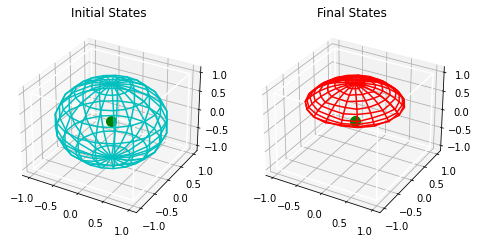

In [60]:
# Set the Initial States
initialStates = computeStateVectorCoordsReshaped(Zero_Amplitude)
# Set the Final States
finalStates = computeStateVectorCoordsReshaped(Zero_AmplitudeF)
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
draw_cube(ax)

# draw initial states
ax.plot_wireframe(initialStates['reshapedCoordsX'], initialStates['reshapedCoordsY'], initialStates['reshapedCoordsZ'], color="c")
ax.set_title("Initial States")
# draw center
ax.scatter([0], [0], [0], color="g", s=100)

#===============
# Second subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
draw_cube(ax)

# draw final states
ax.plot_wireframe(finalStates['reshapedCoordsX'], finalStates['reshapedCoordsY'], finalStates['reshapedCoordsZ'], color="r")
ax.set_title("Final States")
# draw center
ax.scatter([0], [0], [0], color="g", s=100)

plt.show()